In [291]:
import pandas as pd
from pyspark.mllib.recommendation import ALS, Rating

#Provide Path of ratings.csv dataset in "path" variable
path_rating="C:\\Program Files\\Git\\MyGitFilesDirectory\\data\\retail_db\\orders\\ml-latest-small\\ratings.csv"

#Raw Data in RDD
rat=sc.textFile(path_rating)

#Transformation....using first 10000 movieid because rest are outliners
header=rat.first()
ratings=rat.filter(lambda x: x!=header).map(lambda rec:rec.split(","))
ratings=ratings.map(lambda rec: (int(rec[0]),int(rec[1]),float(rec[2]))).filter(lambda x: (x[1]<6000))
ratingsDF=ratings.toDF().na.drop()

In [299]:

#ALS in RDD
ratings = ratings.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
training,test=ratings.randomSplit([0.99,0.01],5)
rank = 50
numIterations = 10
model = ALS.train(training,rank,numIterations,0.01 )
testdataRDD = test.map(lambda p: (p[0], p[1]))
predictionsRDD = model.predictAll(testdataRDD).map(lambda r: (r[1], r[2]))



In [302]:
#ALS in DataFrame
trainingDF,testDF=ratingsDF.randomSplit([0.99,0.01],5)
model1 = ALS.train(trainingDF, rank,numIterations,0.01 )
testdataDF = test.map(lambda p: (p[0], p[1]))
predictionsDF = model1.predictAll(testdataDF).map(lambda r: (r[1],r[2]))


In [300]:
XRDD=predictionsRDD.map(lambda rec:(rec[0])).collect()
YRDD=predictionsRDD.map(lambda rec:(rec[1])).collect()
XDF=predictionsDF.map(lambda rec:(rec[0])).collect()
YDF=predictionsDF.map(lambda rec:(rec[1])).collect()

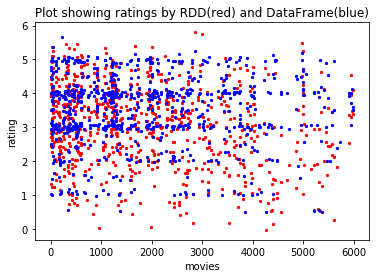

Here it is clearly seen that the predicted rating from RDD is lower than that of DataFrame


In [303]:
import matplotlib.pyplot as plt
plt.scatter(XRDD,YRDD,marker='.',color="red",s=20)
plt.scatter(XDF,YDF,marker='.',color="blue",s=20)
plt.xlabel('movies')
plt.ylabel('rating')
plt.title("Plot showing ratings by RDD(red) and DataFrame(blue)")
plt.legend()
plt.show()
print("Here it is clearly seen that the predicted rating from RDD is lower than that of DataFrame")


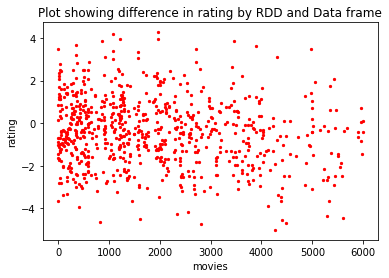

Difference of RDD and DataFrame lying mostly between +2 and -2


In [304]:
diff = [(a - b) for a, b in zip(YRDD, YRDF)]
plt.scatter(XRDD,diff,marker='.',color="red",s=20)
plt.xlabel('movies')
plt.ylabel('rating')
plt.title("Plot showing difference in rating by RDD and Data frame")
plt.legend()
plt.show()
print("Difference of RDD and DataFrame lying mostly between +2 and -2" )

